In [1]:
from utils import file_reader_movie_lens_rating, obj_mapping

rats = file_reader_movie_lens_rating(path='./data/ml-small/ratings.csv', sep=',')

user2ix, ix2user, item2ix, ix2item = obj_mapping(rats)

num_user = len(user2ix.keys())
num_item = len(item2ix.keys())

print(f'Users: {num_user}, Items: {num_item}. Sparsity: {1-len(rats)/num_user/num_item}')

Users: 610, Items: 9724. Sparsity: 0.9830003169443864


In [2]:
from utils import rating_train_test_parser

# split data into training and testing
rat_train_dict, rat_test_dict = rating_train_test_parser(rats)

print(f'User reduced from {len(user2ix.keys())} to {len(rat_train_dict.keys())}')

User reduced from 610 to 607


In [3]:
import torch
from torch import optim
# local model
from model.svd import FunkSVD, BiasedFunkSVD
from utils import train_model

cuda = torch.cuda.is_available()
n_users = len(user2ix)
n_items = len(item2ix)
embed_size = 32

# training settings
num_epochs = 128 # Max number of training epochs
user_per_iter = 256
pos_item_per_iter = 4
neg_item_per_iter = 4
lr = 0.1 # Set the learning rate
reg = 0.01
mom = 0.01

""" 1. The original Funk SVD model """
# model object
svd_raw = FunkSVD(
    n_users, n_items, embed_size
    , negative_sampling=False)
# optimizer
opt_svd_raw = optim.SGD(
    svd_raw.parameters()
    , lr=lr, weight_decay=reg, momentum=mom
)

svd_raw, losses_svd_raw = train_model(
    svd_raw
    , ratings = rat_train_dict
    , items = ix2item
    , n_epochs = num_epochs
    , opt_fn = opt_svd_raw
    , user_size = user_per_iter
    , pos_size = pos_item_per_iter
    , negative_sampling=False
    , cuda=True)

""" 2. Funk SVD model with negative sampling """
svd_ns = FunkSVD(
    n_users, n_items, embed_size
    , negative_sampling=True)

opt_svd_ns = optim.SGD(
    svd_ns.parameters()
    , lr=lr, weight_decay=reg, momentum=mom
) # Select an optimizer

svd_ns, losses_svd_ns = train_model(
    svd_ns
    , ratings = rat_train_dict
    , items = ix2item
    , n_epochs = num_epochs
    , opt_fn = opt_svd_ns
    , user_size = user_per_iter
    , pos_size = pos_item_per_iter
    , neg_size = neg_item_per_iter
    , method = 'list'
    , cuda = True)

""" 3. Biased Funk SVD model """
from utils import compute_rat_bias

# compute bias
global_bias, user_bias, item_bias = compute_rat_bias(rat_train_dict, n_users, n_items)

bsvd_raw = BiasedFunkSVD(
    n_users, n_items, embed_size
    , user_bias
    , item_bias
    , global_bias
    , negative_sampling=False)

opt_bsvd_raw = optim.SGD(
    bsvd_raw.parameters()
    , lr=lr, weight_decay=reg, momentum=mom)

bsvd_raw, losses_bsvd_raw = train_model(
    bsvd_raw
    , ratings = rat_train_dict
    , items = ix2item
    , n_epochs = num_epochs
    , opt_fn = opt_bsvd_raw
    , user_size = user_per_iter
    , pos_size = pos_item_per_iter
    , negative_sampling=False
    , cuda=True)

""" 4. Biased Funk SVD model with negative sampling """
bsvd_ns = BiasedFunkSVD(
    n_users, n_items, embed_size
    , user_bias
    , item_bias
    , global_bias
    , negative_sampling=True)

opt_bsvd_ns = optim.SGD(
    bsvd_ns.parameters()
    , lr=lr, weight_decay=reg, momentum=mom)

bsvd_ns, losses_bsvd_ns = train_model(
    bsvd_ns
    , ratings = rat_train_dict
    , items = ix2item
    , n_epochs = num_epochs
    , opt_fn = opt_bsvd_ns
    , user_size = user_per_iter
    , pos_size = pos_item_per_iter
    , neg_size = neg_item_per_iter
    , method = 'list'
    , cuda=True)

Epoch: 0, Time: 2.04, /Average loss 7.94601
Epoch: 10, Time: 0.17, /Average loss 6.63749
Epoch: 20, Time: 0.19, /Average loss 5.47763
Epoch: 30, Time: 0.19, /Average loss 4.63232
Epoch: 40, Time: 0.19, /Average loss 3.80843
Epoch: 50, Time: 0.16, /Average loss 3.17801
Epoch: 60, Time: 0.2, /Average loss 2.69918
Epoch: 70, Time: 0.2, /Average loss 2.29252
Epoch: 80, Time: 0.27, /Average loss 1.94806
Epoch: 90, Time: 0.19, /Average loss 1.71792
Epoch: 100, Time: 0.22, /Average loss 1.50308
Epoch: 110, Time: 0.19, /Average loss 1.34784
Epoch: 120, Time: 0.22, /Average loss 1.22549
Epoch: 0, Time: 0.71, /Average loss 4.74176
Epoch: 10, Time: 1.09, /Average loss 4.04844
Epoch: 20, Time: 0.87, /Average loss 3.44862
Epoch: 30, Time: 0.81, /Average loss 2.88593
Epoch: 40, Time: 1.33, /Average loss 2.50415
Epoch: 50, Time: 0.99, /Average loss 2.13929
Epoch: 60, Time: 0.7, /Average loss 1.87112
Epoch: 70, Time: 0.71, /Average loss 1.65979
Epoch: 80, Time: 0.78, /Average loss 1.48301
Epoch: 90, T

In [4]:
from eval.evaluator import generate_testing_candidates, predict_recommendation

# change device
svd_raw = svd_raw.to('cpu')
svd_ns = svd_ns.to('cpu')
bsvd_raw = bsvd_raw.to('cpu')
bsvd_ns = bsvd_ns.to('cpu')

# generate testing candidates for all users
testing_candidates = generate_testing_candidates(rat_train_dict, ix2item)

# test model's efficacy
pred_dict_raw = predict_recommendation(svd_raw, testing_candidates)
pred_dict_ns = predict_recommendation(svd_ns, testing_candidates)
pred_dict_bns_raw = predict_recommendation(bsvd_raw, testing_candidates)
pred_dict_bns_ns = predict_recommendation(bsvd_ns, testing_candidates)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


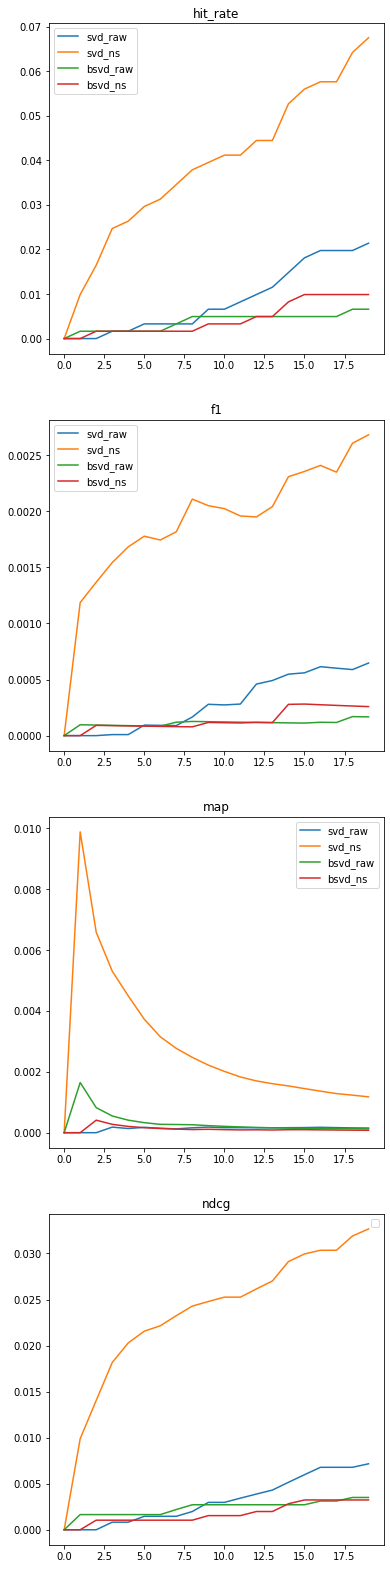

In [5]:
from eval.metric import hit_rate, f1, map, ndcg
import matplotlib.pyplot as plt

k = 20

metrics = {
    'hit_rate': hit_rate
    , 'f1': f1
    , 'map': map
    , 'ndcg': ndcg
}

preds = {
    'svd_raw': pred_dict_raw
    , 'svd_ns': pred_dict_ns
    , 'bsvd_raw': pred_dict_bns_raw
    , 'bsvd_ns': pred_dict_bns_ns
}

fig, ax = plt.subplots(4, figsize=(6, 28))
for i, m_i in enumerate(metrics.keys()):
    val = [[metrics[m_i](ki, rat_test_dict, pred) \
            for pred in preds.values()]\
           for ki in range(k)]
    ax[i].plot(list(range(k)), val)
    ax[i].legend(list(preds.keys()))
    ax[i].set_title(m_i)

plt.legend()
plt.show()